Aluno: Luis Felipe dos Santos Ribeiro
Rio de janeiro, 28 de março de 2022

## Atividade II - Hands on Introduction to Machine Learning

# Primeira Etapa da atividade II - HIML (29/03/2022)

### Importação de pacotes e Leitura do dataset

In [2]:
import pandas as pd
import numpy as np 
import scipy.io as sio 
import matplotlib.pyplot as plt 
from os import getcwd
from os.path import join 

2. Leitura de datasets

In [3]:
mat_contents = sio.loadmat('data3SS2009.mat')
dataset = mat_contents['dataset']
n_samples, n_channels, n_cases = dataset.shape # N, Chno, Nc
y = mat_contents['labels'].reshape(n_cases)

Ch1 = pd.DataFrame(dataset[:,0,:])
Ch2 = pd.DataFrame(dataset[:,1,:])
Ch3 = pd.DataFrame(dataset[:,2,:])
Ch4 = pd.DataFrame(dataset[:,3,:])
Ch5 = pd.DataFrame(dataset[:,4,:])

### Modelo Autoregressivo

Modelo autoregressivo para determinação de coeficientes para aproximação da curva:

- y(t) = c_0 + x1 * t1 + ... xn*tn, com n = número de lags

In [6]:
from statsmodels.tsa.ar_model import AutoReg
Feat = []
lags = 30
for i in range(0,n_cases):
    ar_model_Ch1 = AutoReg(Ch2[i].values, lags = lags).fit()
    ar_model_Ch2 = AutoReg(Ch3[i].values, lags = lags).fit()
    ar_model_Ch3 = AutoReg(Ch4[i].values, lags = lags).fit()
    ar_model_Ch4 = AutoReg(Ch5[i].values, lags = lags).fit()
    ar_models = np.concatenate([ar_model_Ch1.params, ar_model_Ch2.params, ar_model_Ch3.params, ar_model_Ch4.params])
    Feat.append(ar_models)


### Vericando o número de componentes principais -> "Curva de Cotovelo"

Text(0.5, 0, 'n_components')

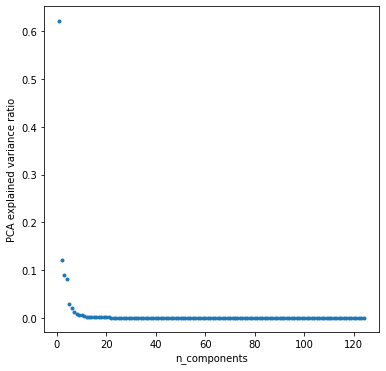

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pca = PCA()
pca.fit(Feat)

# Plot the PCA spectrum
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(6, 6))

ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, ".", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.set_xlabel("n_components")

### Softmax Regression 

1. Novos pacotes

In [8]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn import linear_model

2. Escalando modelo para valores no intervalo (-1,1)

In [9]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
Feat_scaler = min_max_scaler.fit_transform(Feat)
Y = mat_contents['labels'].reshape(n_cases)

3. Criando o modelo:

In [10]:
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.3, random_state = 0 )
modelo_tot = linear_model.LogisticRegression()
modelo_tot.fit(x_train, y_train)

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

4. Predições e aferições quanto a qualidade do modelo:

[[17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14]]
0.996078431372549


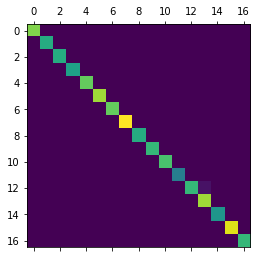

In [11]:
y_pred = modelo_tot.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
plt.matshow(cm)
print(cm) 
print(ac)

### Softmax usando outro método para escalar as variáveis:

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14]]
0.996078431372549


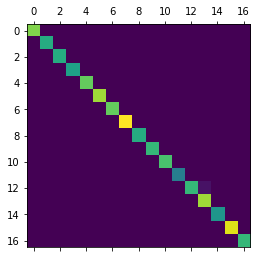

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df = sc.fit_transform(Feat)

x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size = 0.3, random_state = 0 )
modelo_tot = linear_model.LogisticRegression()
modelo_tot.fit(x_train, y_train)

y_pred = modelo_tot.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
plt.matshow(cm)
print(cm) 
print(ac)

In [13]:
# 1 -> PCA
pca1 = PCA(n_components = 7)
pca1.fit(Feat)
x_pca = pca1.transform(Feat)
print("Original shape: {}".format(str(np.shape(Feat))))
print("Reduced shape: {}".format(str(np.shape(x_pca))))


Original shape: (850, 124)
Reduced shape: (850, 7)


C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  1  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 12  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1 13  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14]]
0.9529411764705882


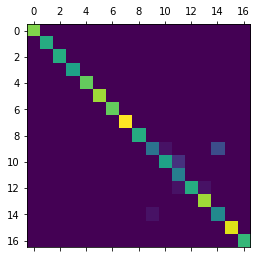

In [14]:
# 1 -> Scalling of PCA components matriz:
sc = StandardScaler()
df = sc.fit_transform(x_pca)

# 3 -> Setting train and test data
Y = mat_contents['labels'].reshape(n_cases)
x_train, x_test, y_train, y_test = train_test_split(x_pca, Y, test_size = 0.3, random_state = 0 )
modelo_tot = linear_model.LogisticRegression()
modelo_tot.fit(x_train, y_train)

# 4 -> 
y_pred = modelo_tot.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
plt.matshow(cm)
print(cm) 
print(ac) 

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

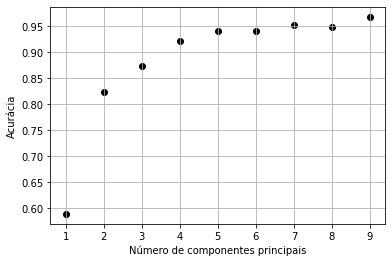

In [15]:
for i in range(1,10):
    pca1 = PCA(n_components = i)
    pca1.fit(Feat)
    x_pca = pca1.transform(Feat)
    
    Y = mat_contents['labels'].reshape(n_cases)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, Y, test_size = 0.3, random_state = 0)
    modelo_tot = linear_model.LogisticRegression()
    modelo_tot.fit(x_train, y_train)
    y_pred = modelo_tot.predict(x_test)
    ac = accuracy_score(y_test, y_pred)
    plt.figure(1)
    plt.xlabel('Número de componentes principais')
    plt.ylabel('Acurácia')
    plt.grid()
    plt.scatter(i, ac, color = 'black') 

### Função para plot agradável da M. confusão:

In [33]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Segunda Etapa da atividade II - HIML (05/04/2022)

## Uso de SVM

In [16]:
from sklearn.svm import LinearSVC, LinearSVR

In [18]:
mat_contents = sio.loadmat('data3SS2009.mat')
dataset = mat_contents['dataset']
n_samples, n_channels, n_cases = dataset.shape # N, Chno, Nc
y = mat_contents['labels'].reshape(n_cases)

Ch1 = pd.DataFrame(dataset[:,0,:])
Ch2 = pd.DataFrame(dataset[:,1,:])
Ch3 = pd.DataFrame(dataset[:,2,:])
Ch4 = pd.DataFrame(dataset[:,3,:])
Ch5 = pd.DataFrame(dataset[:,4,:])

In [19]:
from statsmodels.tsa.ar_model import AutoReg
Feat = []
lags = 30
for i in range(0,n_cases):
    ar_model_Ch1 = AutoReg(Ch2[i].values, lags = lags).fit()
    ar_model_Ch2 = AutoReg(Ch3[i].values, lags = lags).fit()
    ar_model_Ch3 = AutoReg(Ch4[i].values, lags = lags).fit()
    ar_model_Ch4 = AutoReg(Ch5[i].values, lags = lags).fit()
    ar_models = np.concatenate([ar_model_Ch1.params, ar_model_Ch2.params, ar_model_Ch3.params, ar_model_Ch4.params])
    Feat.append(ar_models)

Text(0.5, 0, 'n_components')

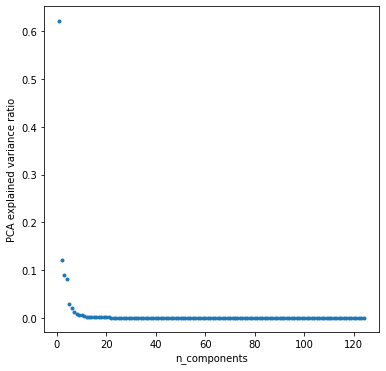

In [20]:
pca = PCA()
pca.fit(Feat)

# Plot the PCA spectrum
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(6, 6))

ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, ".", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.set_xlabel("n_components")

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


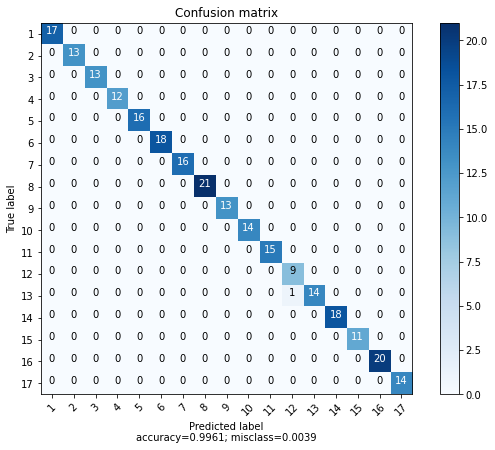

In [36]:
from sklearn.svm import LinearSVC

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
Feat_scaler = min_max_scaler.fit_transform(Feat)
Y = mat_contents['labels'].reshape(n_cases)

x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.3, random_state = 0 )
modelo_tot = LinearSVC(C = 1, loss = 'hinge', random_state = 42)
modelo_tot.fit(x_train, y_train)

y_pred = modelo_tot.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(1,18))

## Validação Cruzada

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modelo_tot, X = x_train, y = y_train, scoring = 'neg_mean_squared_error' , cv = 10)

svg_rmse_scores = np.sqrt(-scores)
print(svg_rmse_scores)

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.13018891]


C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Um único conjunto apresentou erro médio quadrático!

## Uso do KNN

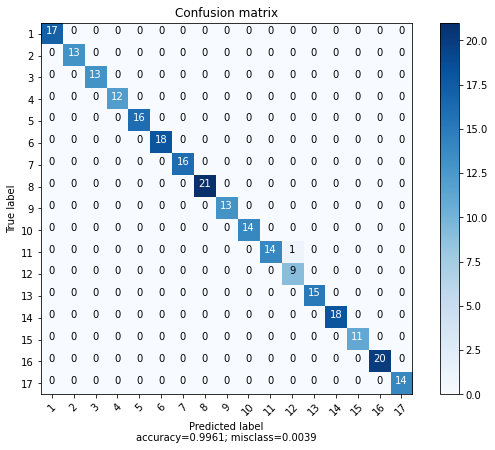

In [38]:
from sklearn.neighbors import KNeighborsClassifier

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
Feat_scaler = min_max_scaler.fit_transform(Feat)
Y = mat_contents['labels'].reshape(n_cases)

x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.3, random_state = 0 )
modelo_tot = KNeighborsClassifier(n_neighbors = 1)
modelo_tot.fit(x_train, y_train)

y_pred = modelo_tot.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(1,18))